In [1]:
# Calcolo fluttuazioni di velocità

In [2]:
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import numpy as np
from math import *
from statistics import stdev
import matplotlib.pyplot as plt
from openpiv import tools, pyprocess, validation, filters, scaling 
from matplotlib.patches import Ellipse


In [3]:
u_thresholds = (-5.5,7)
v_thresholds = (0,4)

In [4]:
folder = '/home/matteo/PIV/PIV'

Data = np.genfromtxt(folder + '/win_def/Open_PIV_results_32_Test_1/exp1_001.txt',
    delimiter='	',
    names=True,
    dtype=None)
u = Data['u']
v = Data['v']
u = u.flatten()
v = v.flatten()
mask = Data['mask']
mask = mask.flatten()


Data_dirty = np.genfromtxt(folder + '/Vector_field/exp1_001.txt',
    delimiter='	',
    names=True,
    dtype=None)
u_dirty = Data_dirty['u']
v_dirty = Data_dirty['v']
u_dirty = u_dirty.flatten()
v_dirty = v_dirty.flatten()


In [5]:
# Generate strings for the images
numbers = ["{0:03}".format(i) for i in range(2,101)]

In [6]:
# Save vector field for all the images
for i in numbers:
    Data = np.genfromtxt(folder + '/win_def/Open_PIV_results_32_Test_1/exp1_' + i + '.txt',
        delimiter='	',
        names=True,
        dtype=None)
    uv = Data['u']
    vv = Data['v']
    uv = uv.flatten()
    vv = vv.flatten()
    u = np.c_[u,uv]
    v = np.c_[v,vv]
    maskv = Data['mask']
    maskv = maskv.flatten()
    mask = np.c_[mask, maskv]
    
    Data_dirty = np.genfromtxt(folder + '/Vector_field/exp1_' + i + '.txt',
        delimiter='	',
        names=True,
        dtype=None)
    uv_dirty = Data_dirty['u']
    vv_dirty = Data_dirty['v']
    uv_dirty = uv_dirty.flatten()
    vv_dirty = vv_dirty.flatten()
    u_dirty = np.c_[u_dirty,uv_dirty]
    v_dirty = np.c_[v_dirty,vv_dirty]

In [7]:
i

'100'

In [8]:
vect_substitute = sum(mask)
print(vect_substitute)
print(np.sum(vect_substitute))
print('Percentual: {} %'.format(np.sum(vect_substitute)/(61*61)))

[ 4.  3.  8.  3.  8.  3.  2.  1.  1.  1.  1.  3.  8.  0.  2.  6.  4.  2.
  4.  2.  6.  1.  1.  1.  3.  2.  1.  2.  1.  4. 18.  1.  2.  1.  3.  4.
  1.  2.  3.  1.  2.  1.  2. 10.  3.  0.  1.  8.  6.  3.  4.  0.  1.  0.
 17.  3.  3.  1.  2.  2. 24.  6.  4.  2.  1.  9.  2.  1.  9.  1.  1.  2.
 13.  2. 10.  1.  4.  1.  2.  1.  4. 12.  2.  1.  3.  3.  0. 19.  1.  3.
  1.  2.  3.  1.  2.  1.  1.  0.  2. 17.]
367.0
Percentual: 0.0986294006987369 %


In [9]:
# Save mean flow
MeanData = np.genfromtxt(folder + '/win_def/Open_PIV_results_32_Test_1/meanField.txt',
    delimiter='	',
    names=True,
    dtype=None)

X, Y = MeanData['x'], MeanData['y']
u_mean = MeanData['u']
v_mean = MeanData['v']

In [10]:
# My field 
x1 = X[0]
y1 = Y[0]
n = np.sum(X==x1)
m = np.sum(Y==y1)
n_images = u.shape[1]
print(n) # intervalli in y
print(m) # intervalli in x

61
61


In [11]:
# cerco le dimensioni dei vettori "dirty"

x_dirty = Data_dirty['x']
y_dirty = Data_dirty['y']

x1_dirty = x_dirty[0]
y1_dirty = y_dirty[0]

n_dirty = np.sum(x_dirty==x1_dirty)
m_dirty = np.sum(y_dirty==y1_dirty)

print(n_dirty) # intervalli in y
print(m_dirty) # intervalli in x

61
61


In [12]:
X_1 = X.reshape(n,m)
Y_1 = Y.reshape(n,m)

In [13]:
# The mathematical approximation function is U:
def U(x, y, A, B):
  return (A/(x)) * np.exp(-((y)**2)/((B*(x))**2))
# return (A/(x-x0)) * np.exp(-(y-y0)**2/(B*(x-x0)))


# This is the callable that is passed to curve_fit.M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def func(M, *args):
  xx, yy = M
  arr = np.zeros(xx.shape)
  arr += U(xx, yy, *args)
  return arr

# origin of the nozzle
x0 = 45/2 + 80  # 45/2 sarebbe il centro della finestra + 80mm distanza dall'ugello [ref PIV challenge]
y0 = 45/2       # CHECK!!!!!!!!!!!!!!!!!

# mean centerline  velocity
# A == p_opt[0]
def U_centerline(x, x0, A):
  return A/(x-x0) 

# mean jet width
# B == p_opt[1]
def jet_width(x, x0, B):
  return (x-x0)*B

# reduced radial coordinate
def similarity_variable(y, y0, *args):
  width = args
  return (y-y0)/width

In [14]:
p_opt = np.zeros(2)
p_opt[0], p_opt[1] = -1.38665305e+04, -9.72292210e-02

In [15]:
coord = np.vstack((-X + x0, Y - y0))
U_mean = func(coord, p_opt[0], p_opt[1])

In [16]:
U_c = U_centerline(X_1[0,:], x0, p_opt[0])
Width = jet_width(X_1[0,:], x0, p_opt[1])

In [17]:
# Creating field of fluctuations
u_prime_vect = np.zeros(u.shape[0])
u_prime_field = np.zeros((n,m))
u_prime = np.zeros((n,m,n_images))
u_tot = np.zeros((n,m,n_images))
v_tot = np.zeros((n,m,n_images))

u_tot_dirty = np.zeros((n_dirty,m_dirty,n_images))
v_tot_dirty = np.zeros((n_dirty,m_dirty,n_images))
for j in range(n_images):
    u_prime_vect[:] = u[:,j] - u_mean
    u_prime_field = u_prime_vect.reshape(n,m)
    u_prime[:,:,j] = u_prime_field
    u_tot[:,:,j] = u[:,j].reshape(n,m)
    v_tot[:,:,j] = v[:,j].reshape(n,m)
    u_tot_dirty[:,:,j] = u_dirty[:,j].reshape(n_dirty,m_dirty)
    v_tot_dirty[:,:,j] = v_dirty[:,j].reshape(n_dirty,m_dirty)
'''
print(u_prime_field)
print()
print()
print()
print(u_prime)
'''
img = 0 # image number
print(u_prime[:,:,img]-(u[:,img] - u_mean).reshape(n,m))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


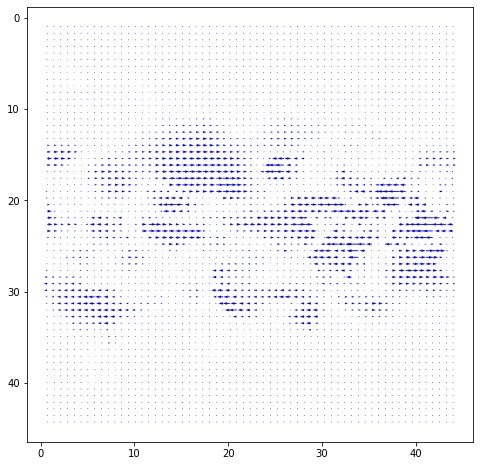

In [18]:
resolution = (992,1004) #pixel
physical_window = (45,45) # m
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel

vmean = np.zeros(X.shape)
mask = np.zeros(X.shape, dtype=bool)
snr = np.zeros(X.shape)
uprime = u[:,img] - u_mean # differenza tra campo di moto - medio
tools.save(X, Y, uprime, vmean, snr, mask, folder + '/Vector_field/' + 'test_turbulence.txt' )

fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field( folder + '/Vector_field/' + 'test_turbulence.txt' , 
                           ax=ax, scaling_factor=scaling_factor, 
                           scale= 5000, # scale defines here the arrow length
                           width= 0.002, # width is the thickness of the arrow
                           on_img=False, # overlay on the image
                           image_name= 'None');

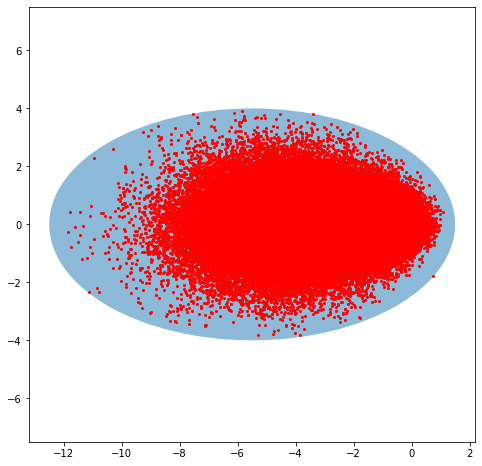

In [19]:
# voglio plottare l'ellisse
delta_px_x = u_tot*scaling_factor*0.0012
delta_px_y = v_tot*scaling_factor*0.0012

plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.plot(delta_px_x.flatten(),delta_px_y.flatten(),'or',markersize=2)
ells = Ellipse(xy=(u_thresholds[0],v_thresholds[0]), width=2*u_thresholds[1], height=2*v_thresholds[1], angle=0, alpha = 0.5)
ax.add_patch(ells)
plt.axis('equal')
plt.savefig('../Immagini_relazione/ellisse_esatta.png',format = 'png', dpi = 1e3)
plt.show()

MAX = np.amax(abs(u_prime))

2002
Percentual: 0.5380274119860252 %


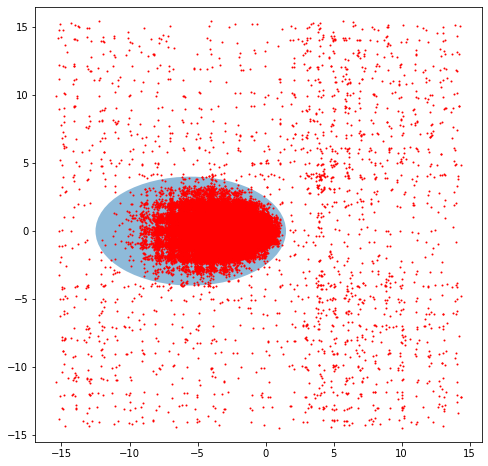

In [20]:
delta_px_x_dirty = u_tot_dirty*scaling_factor*0.0012
delta_px_y_dirty = v_tot_dirty*scaling_factor*0.0012
ind = ((((delta_px_x_dirty-u_thresholds[0])/u_thresholds[1])**2 + ((delta_px_y_dirty-v_thresholds[0])/v_thresholds[1])**2) > 1)
out_ell = np.sum(ind)
print(out_ell)
print('Percentual: {} %'.format(out_ell/(n*m)))

plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.plot(delta_px_x_dirty.flatten(),delta_px_y_dirty.flatten(),'or',markersize=1)
ells = Ellipse(xy=(u_thresholds[0],v_thresholds[0]), width=2*u_thresholds[1], height=2*v_thresholds[1], angle=0, alpha = 0.5)
ax.add_patch(ells)
plt.axis('equal')
plt.savefig('../Immagini_relazione/ellisse_firstguess.png',format = 'png', dpi = 1e3)
plt.show()


x = 22.3422 mm


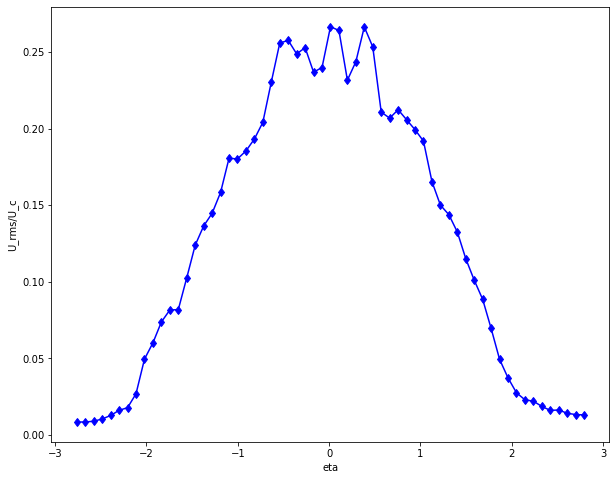

In [29]:
# plotto i profili di similarità delle 100 immagini tutti alla stessa x

m2 = m//2
x_2 = X_1[0,m2]
eta_2 = similarity_variable(Y_1[:,0], y0, Width[m2])
print('x =', x_2, 'mm')

uprime_2 = np.zeros((n,n_images))
for t in range(n_images):
    uprime_2[:,t] = u_prime[:,m2,t]
'''
uprime_2mean = np.zeros(n)
for s in range(n):
    uprime_2mean[s] = np.mean(uprime_2[s,:])
'''
u_rms = np.zeros(n)
for a in range(n):
    u_rms[a] = sqrt(1/n_images*np.dot(uprime_2[a,:],uprime_2[a,:]))
    
plt.figure(figsize=(10, 8))
plt.plot(eta_2, u_rms/U_c[m2],'b-d')
plt.xlabel('eta')
plt.ylabel('U_rms/U_c') # diviso U_c ??? 
plt.savefig('../Immagini_relazione/Urms_x22_3422.png',format = 'png', dpi = 1e3)
plt.show()

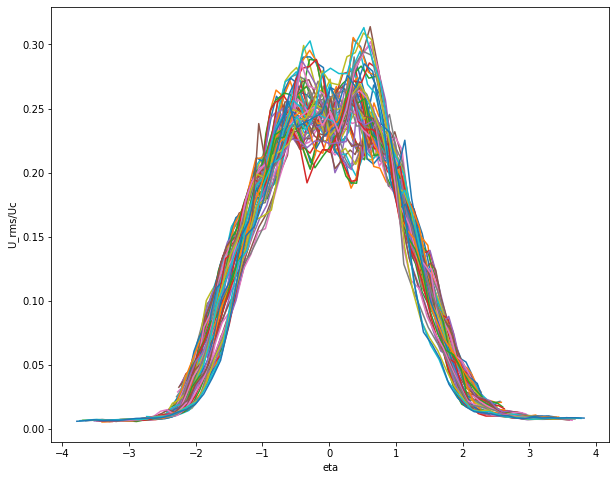

In [30]:
# plotto tutti i profili di similarità        

u_rms_field = np.zeros((n,m))
for a in range(n):
    for b in range(m):
        u_rms_field[a,b] = sqrt(1/n_images*np.dot(u_prime[a,b,:],u_prime[a,b,:]))
    
ETA = np.zeros((n, m))
u_rms_normalized = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        ETA[i, j] = similarity_variable(Y_1[i,0], y0, Width[j])
        u_rms_normalized[i, j] = u_rms_field[i, j]/U_c[j]
        
plt.figure(figsize=(10, 8))
plt.plot(ETA, u_rms_normalized)
plt.xlabel('eta')
plt.ylabel('U_rms/Uc')
plt.savefig('../Immagini_relazione/Urms_similarity.png',format = 'png', dpi = 1e3)
plt.show()

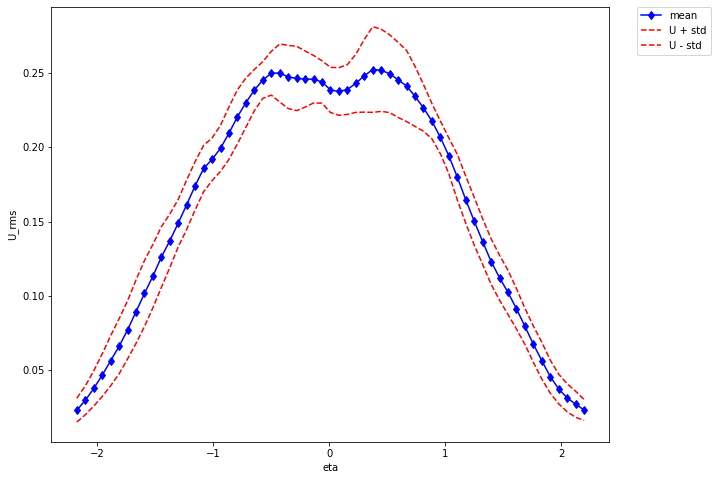

In [27]:
u_rms_norm_mean = np.zeros(n)
errU_rms = np.zeros(n)
ETA0 = ETA[:,0]
U_x = np.zeros((n, m))
U_x[:,0] = u_rms_normalized[:,0]
for s in range(m-1):
    U_x[:,s+1] = np.interp(ETA0, ETA[:, s+1], u_rms_normalized[:, s+1])
    
for t in range(n):
    u_rms_norm_mean[t] = np.mean(U_x[t,:])
    errU_rms [t] = stdev(U_x[t,:])

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(ETA0, u_rms_norm_mean, 'b-d', label='mean')
plt.plot(ETA0, u_rms_norm_mean + errU_rms, 'r--', label='U + std')
plt.plot(ETA0, u_rms_norm_mean - errU_rms, 'r--', label='U - std')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('eta')
plt.ylabel('U_rms')
fig.savefig('../Immagini_relazione/u_mean.png',format = 'png', dpi = 1e3)

plt.show()

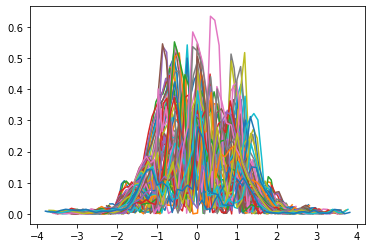

In [24]:
# plotto i profili di similarità a diverse x della stessa immagine 
image = 0
ETA = np.zeros((n, m))
uprime_normalized = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        ETA[i, j] = similarity_variable(Y_1[i,0], y0, Width[j])
        uprime_normalized[i, j] = u_prime[i, j, image]/U_c[j]

plt.plot(ETA, abs(uprime_normalized))
plt.show()



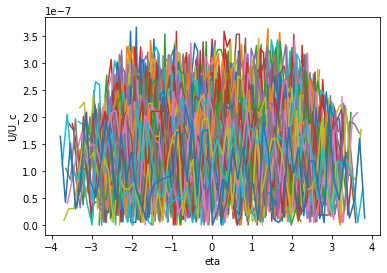

In [25]:

uprime_mean = np.zeros((n,n_images))
uprime_mean_field = np.zeros((n,m))
for k in range(m):
    for r in range(n_images):
        uprime_mean[:,r] = u_prime[:,k,r]
    for g in range(n):
        uprime_mean_field[g,k] = np.mean(uprime_mean[g,:])
        
for i in range(n):
    for j in range(m):
        uprime_mean_field[i, j] = abs(uprime_mean_field[i, j])/U_c[j]

plt.plot(ETA, uprime_mean_field)
plt.xlabel('eta')
plt.ylabel('U/U_c')
plt.show()

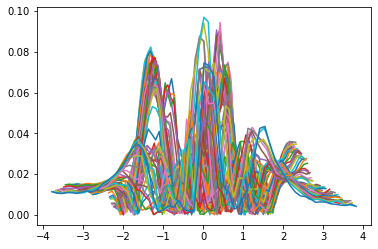

In [26]:
# plotto i profili di similarità a diverse x della stessa immagine 
uprime_test = (u_mean - U_mean).reshape(n,m)
uprime_normalized_test = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        uprime_normalized_test[i, j] = abs(uprime_test[i, j])/U_c[j]
plt.plot(ETA, uprime_normalized_test)
plt.show()